In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
csde_df = pd.read_csv("../../dataset/drug_switches_closest.tsv", sep="\t")

In [6]:
csde_df.head()


,eid,A_drug_era_id,A_drug_concept_id,A_drug_era_start_date,A_drug_era_end_date,A_drug_exposure_count,A_gap_days,B_drug_era_id,B_drug_concept_id,B_drug_era_start_date,B_drug_era_end_date,B_drug_exposure_count,B_gap_days,switch_interval
0,1000014,1365799655232,1124300,2008-04-29,2008-06-09,1,0,171798743567,1178663,2008-09-23,2008-10-13,1,0,106
1,1000014,1365799655232,1124300,2008-04-29,2008-06-09,1,0,240518240204,923645,2008-09-23,2008-10-20,1,0,106
2,1000014,1365799655232,1124300,2008-04-29,2008-06-09,1,0,369367235575,836715,2008-09-23,2008-10-06,1,0,106
3,1000014,1365799655232,1124300,2008-04-29,2008-06-09,1,0,1494648709321,1103314,2008-09-23,2008-10-09,1,0,106
4,1000014,171798743567,1178663,2008-09-23,2008-10-13,1,0,532576013874,1769535,2009-04-15,2009-04-19,1,0,184


### basic info

In [4]:
print(len(csde_df))
print(len(csde_df["A_drug_era_id"].unique()))
print(len(csde_df["eid"].unique()))


37254676
18926988
243710


In [5]:
csde_df["switch_interval"] = (
    csde_df["switch_interval"].str.extract(r"(\d+)").astype(int)
)
csde_df["switch_interval"].describe()

count    3.725468e+07
mean     8.545716e+01
std      1.942293e+02
min      1.000000e+00
25%      2.700000e+01
50%      4.300000e+01
75%      7.300000e+01
max      9.660000e+03
Name: switch_interval, dtype: float64

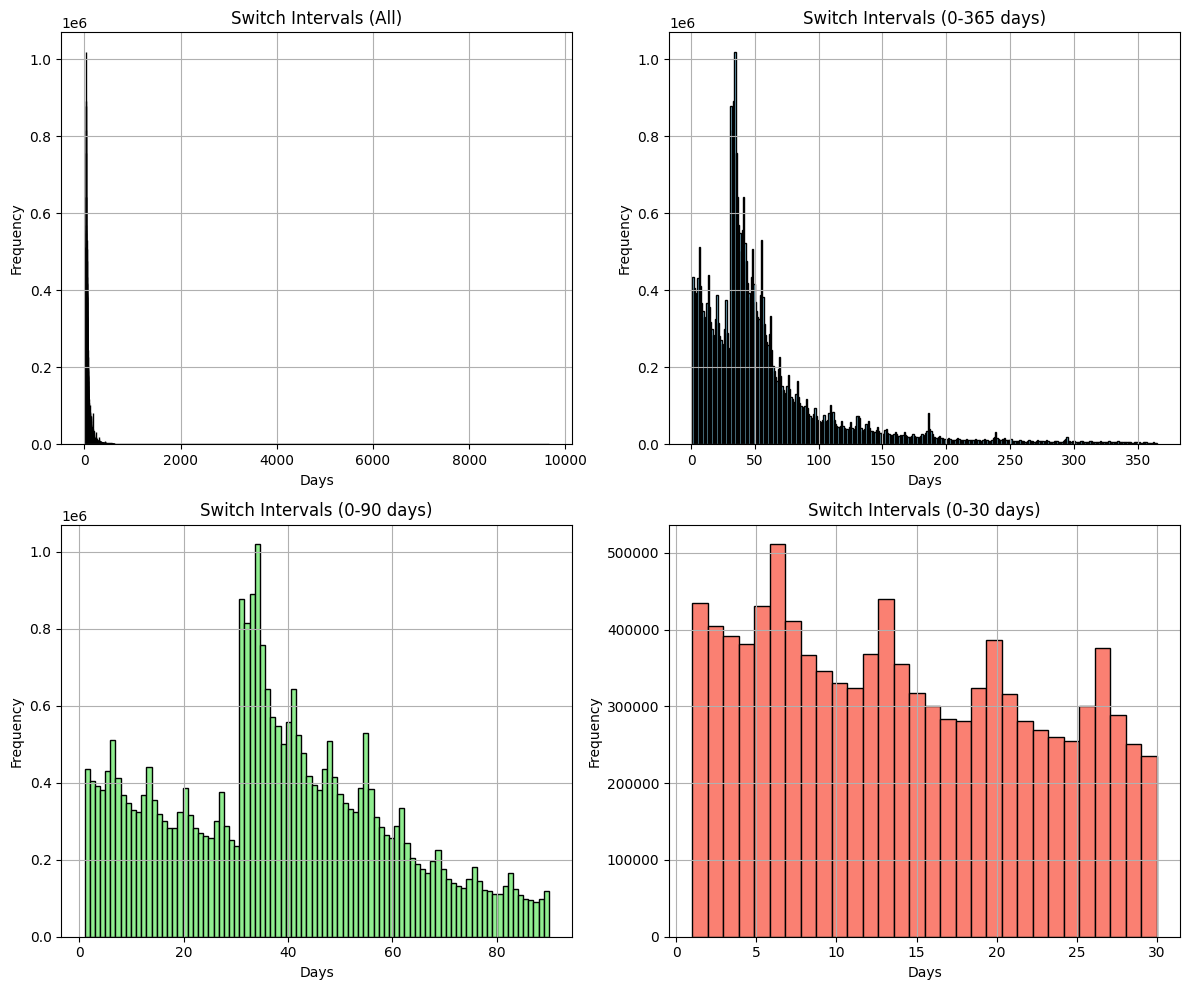

In [68]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Plot for all intervals (no cutoff)
csde_df["switch_interval"].hist(bins=10000, ax=ax1, color="purple", edgecolor="black")
ax1.set_title("Switch Intervals (All)")
ax1.set_xlabel("Days")
ax1.set_ylabel("Frequency")

# Plot for 0-365 days
csde_df[csde_df["switch_interval"] <= 365]["switch_interval"].hist(
    bins=365, ax=ax2, color="skyblue", edgecolor="black"
)
ax2.set_title("Switch Intervals (0-365 days)")
ax2.set_xlabel("Days")
ax2.set_ylabel("Frequency")

# Plot for 0-90 days
csde_df[csde_df["switch_interval"] <= 90]["switch_interval"].hist(
    bins=90, ax=ax3, color="lightgreen", edgecolor="black"
)
ax3.set_title("Switch Intervals (0-90 days)")
ax3.set_xlabel("Days")
ax3.set_ylabel("Frequency")

# Plot for 0-30 days
csde_df[csde_df["switch_interval"] <= 30]["switch_interval"].hist(
    bins=30, ax=ax4, color="salmon", edgecolor="black"
)
ax4.set_title("Switch Intervals (0-30 days)")
ax4.set_xlabel("Days")
ax4.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [24]:
# switch with same drug
print(len(csde_df[csde_df["A_drug_concept_id"] == csde_df["B_drug_concept_id"]]))
# ratio
print(
    len(csde_df[csde_df["A_drug_concept_id"] == csde_df["B_drug_concept_id"]])
    / len(csde_df)
)


5978429
0.1604745938469576


In [64]:
csde_df_365d = csde_df[csde_df["switch_interval"] <= 365]
csde_df_90d = csde_df[csde_df["switch_interval"] <= 90]
csde_df_60d = csde_df[csde_df["switch_interval"] <= 60]
csde_df_30d = csde_df[csde_df["switch_interval"] <= 30]
csde_df_15d = csde_df[csde_df["switch_interval"] <= 15]
csde_df_7d = csde_df[csde_df["switch_interval"] <= 7]


In [65]:
print(len(csde_df_365d))
print(len(csde_df_90d))
print(len(csde_df_60d))
print(len(csde_df_30d))
print(len(csde_df_15d))
print(len(csde_df_7d))


35946714
30091057
25379871
10221421
5813026
2966123


### atc code

In [28]:
atc_df = pd.read_csv("../../dataset/atc_codes_combined.tsv", sep="\t")

In [25]:
def find_switches_within_atc_level(drug_switch_df, atc_df, n):
    """
    Find drug switches where drugs share the same ATC code at the specified level.

    Args:
        drug_switch_df (pd.DataFrame): DataFrame containing drug switch information
        atc_df (pd.DataFrame): DataFrame containing ATC codes for drugs
        n (int): ATC level (1-5) to compare

    Returns:
        pd.DataFrame: Filtered drug switch DataFrame where drugs share same ATC level
    """
    if not 1 <= n <= 5:
        raise ValueError("ATC level must be between 1 and 5")

    # Create mappings of drug_concept_id to list of ATC codes
    drug_to_atc = atc_df.groupby("drug_concept_id")["atc_code"].agg(list).to_dict()

    def get_atc_level_n(atc_codes, n):
        # Extract nth level from list of ATC codes
        if not isinstance(atc_codes, list):
            return set()
        return {code[: n * 2 - 1] for code in atc_codes if len(code) >= n * 2 - 1}

    # Function to check if two drugs share same ATC level
    def share_atc_level(drug_a_id, drug_b_id):
        atc_a = get_atc_level_n(drug_to_atc.get(drug_a_id, []), n)
        atc_b = get_atc_level_n(drug_to_atc.get(drug_b_id, []), n)
        return bool(atc_a & atc_b)  # Check for non-empty intersection

    # Apply filter using vectorized operations
    mask = drug_switch_df.apply(
        lambda row: share_atc_level(row["A_drug_concept_id"], row["B_drug_concept_id"]),
        axis=1,
    )

    return drug_switch_df[mask]

In [53]:
switches_all_3rd_atc = find_switches_within_atc_level(csde_df, atc_df, 3)

In [66]:
switches_365d_3rd_atc = find_switches_within_atc_level(csde_df_365d, atc_df, 3)
switches_90d_3rd_atc = find_switches_within_atc_level(csde_df_90d, atc_df, 3)
switches_60d_3rd_atc = find_switches_within_atc_level(csde_df_60d, atc_df, 3)
switches_30d_3rd_atc = find_switches_within_atc_level(csde_df_30d, atc_df, 3)
switches_15d_3rd_atc = find_switches_within_atc_level(csde_df_15d, atc_df, 3)
switches_7d_3rd_atc = find_switches_within_atc_level(csde_df_7d, atc_df, 3)

In [73]:
print(len(switches_all_3rd_atc))
print(len(switches_365d_3rd_atc))
print(len(switches_90d_3rd_atc))
print(len(switches_60d_3rd_atc))
print(len(switches_30d_3rd_atc))
print(len(switches_15d_3rd_atc))
print(len(switches_7d_3rd_atc))

5834246
5730430
4814220
3869382
88933
53308
28320


In [72]:
print(
    len(
        switches_all_3rd_atc[
            switches_all_3rd_atc["A_drug_concept_id"]
            == switches_all_3rd_atc["B_drug_concept_id"]
        ]
    )
)
print(
    len(
        switches_all_3rd_atc[
            switches_all_3rd_atc["A_drug_concept_id"]
            == switches_all_3rd_atc["B_drug_concept_id"]
        ]
    )
    / len(switches_all_3rd_atc)
)  # ratio: in switches_all_3rd_atc, 94.06% are with the same drug
print(
    len(
        switches_365d_3rd_atc[
            switches_365d_3rd_atc["A_drug_concept_id"]
            == switches_365d_3rd_atc["B_drug_concept_id"]
        ]
    )
)
print(
    len(
        switches_365d_3rd_atc[
            switches_365d_3rd_atc["A_drug_concept_id"]
            == switches_365d_3rd_atc["B_drug_concept_id"]
        ]
    )
    / len(switches_365d_3rd_atc)
)  # ratio
print(
    len(
        switches_90d_3rd_atc[
            switches_90d_3rd_atc["A_drug_concept_id"]
            == switches_90d_3rd_atc["B_drug_concept_id"]
        ]
    )
)
print(
    len(
        switches_90d_3rd_atc[
            switches_90d_3rd_atc["A_drug_concept_id"]
            == switches_90d_3rd_atc["B_drug_concept_id"]
        ]
    )
    / len(switches_90d_3rd_atc)
)  # ratio
print(
    len(
        switches_60d_3rd_atc[
            switches_60d_3rd_atc["A_drug_concept_id"]
            == switches_60d_3rd_atc["B_drug_concept_id"]
        ]
    )
)
print(
    len(
        switches_60d_3rd_atc[
            switches_60d_3rd_atc["A_drug_concept_id"]
            == switches_60d_3rd_atc["B_drug_concept_id"]
        ]
    )
    / len(switches_60d_3rd_atc)
)  # ratio

5487973
0.940648200298719
5400031
0.9423430702408022
4570964
0.9494713577692752
3669283
0.948286573928343


In [76]:
switches_all_3rd_atc["switch_interval"].describe()

count    5.834246e+06
mean     7.672074e+01
std      1.166868e+02
min      1.000000e+00
25%      3.700000e+01
50%      4.900000e+01
75%      7.200000e+01
max      8.633000e+03
Name: switch_interval, dtype: float64

In [80]:
# filter out same drug
switches_all_3rd_atc_no_same_drug = switches_all_3rd_atc[
    switches_all_3rd_atc["A_drug_concept_id"]
    != switches_all_3rd_atc["B_drug_concept_id"]
]

In [82]:
switches_all_3rd_atc_no_same_drug["switch_interval"].describe()

count    346273.000000
mean        101.764157
std         186.855913
min           1.000000
25%          29.000000
50%          50.000000
75%         109.000000
max        8237.000000
Name: switch_interval, dtype: float64

In [74]:
switches_all_2nd_atc = find_switches_within_atc_level(csde_df, atc_df, 2)

In [75]:
print(len(switches_all_2nd_atc))
print(
    len(
        switches_all_2nd_atc[
            switches_all_2nd_atc["A_drug_concept_id"]
            == switches_all_2nd_atc["B_drug_concept_id"]
        ]
    )
)
print(
    len(
        switches_all_2nd_atc[
            switches_all_2nd_atc["A_drug_concept_id"]
            == switches_all_2nd_atc["B_drug_concept_id"]
        ]
    )
    / len(switches_all_2nd_atc)
)  # ratio: in switches_all_2nd_atc, how many are with the same drug

7177966
5487973
0.7645582327918522


In [84]:
switches_all_2nd_atc["switch_interval"].describe()

count    7.177966e+06
mean     7.941966e+01
std      1.317307e+02
min      1.000000e+00
25%      3.600000e+01
50%      4.900000e+01
75%      7.500000e+01
max      8.633000e+03
Name: switch_interval, dtype: float64

In [85]:
switches_all_2nd_atc_no_same_drug = switches_all_2nd_atc[
    switches_all_2nd_atc["A_drug_concept_id"]
    != switches_all_2nd_atc["B_drug_concept_id"]
]

In [86]:
switches_all_2nd_atc_no_same_drug["switch_interval"].describe()

count    1.689993e+06
mean     9.331525e+01
std      1.836765e+02
min      1.000000e+00
25%      3.100000e+01
50%      4.900000e+01
75%      9.300000e+01
max      8.237000e+03
Name: switch_interval, dtype: float64

### common switch

a row -> switch feature tuple: (A_drug_concept_id, B_drug_concept_id)
count the number of occurence for each unique tuple